# Regresión Logística Multiclase (One-vs-All) — Forest Cover Type
Autor: <Tu Nombre> | Grupo: <Tu grupo> | Fecha: <dd/mm/aaaa>

Objetivo: Entrenar un modelo de **regresión logística multiclase** (One-vs-All) con un dataset de **n>10** atributos y **m≥20000** ejemplos, usando **split estratificado 80/20**, **Pandas** para preprocesamiento, **gráficas de costo y precisión**, y un manejo de **desbalanceo** “en lo posible” (ponderación por clase).


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **1) Imports y utilidades**

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from scipy.optimize import minimize

plt.rcParams["figure.figsize"] = (7.5, 5)
plt.rcParams["axes.grid"] = True
np.random.seed(42)


**Carga del dataset (Forest Cover Type) y EDA rápido con Pandas**

In [32]:
# Ruta a tu archivo CSV en Drive
file_path = "/content/drive/MyDrive/Programas de IA/Laboratorios/laboratorio4/covtype.csv"

# Cargar el dataset con Pandas
df = pd.read_csv(file_path)

# Asegurar que la columna objetivo se llame igual que antes
if "Cover_Type" not in df.columns:
    df.rename(columns={df.columns[-1]: "Cover_Type"}, inplace=True)

print("Shape:", df.shape)
df.head(3)


Shape: (581012, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2


In [33]:
# Chequeo rápido
display(df.info())
display(df.isna().sum().to_frame("nulos").T)

# Distribución de clases
vc = df["Cover_Type"].value_counts().sort_index()
display(vc.to_frame("conteo"))
print("Total:", len(df))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

None

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
nulos,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,conteo
Cover_Type,
1,211840
2,283301
3,35754
4,2747
5,9493
6,17367
7,20510


Total: 581012


# **Separación de variables continuas vs. binarias y escalado**

In [34]:
cont_cols = [
    "Elevation","Aspect","Slope",
    "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am","Hillshade_Noon","Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]
all_features = [c for c in df.columns if c != "Cover_Type"]
bin_cols = [c for c in all_features if c not in cont_cols]

# Escalado de continuas
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[cont_cols] = scaler.fit_transform(df_scaled[cont_cols])

# X, y
X = df_scaled[all_features].to_numpy(dtype=np.float64)
y = (df_scaled["Cover_Type"].to_numpy(dtype=np.int64) - 1)   # y en 0..6

num_labels = len(np.unique(y))
X.shape, y.shape, num_labels


((581012, 54), (581012,), 7)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

def dist_pct(vec):
    return (pd.Series(vec).value_counts(normalize=True).sort_index()*100).round(2)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Distribución clases Train %:\n", dist_pct(y_train))
print("Distribución clases Test %:\n",  dist_pct(y_test))


Train: (464809, 54) Test: (116203, 54)
Distribución clases Train %:
 0    36.46
1    48.76
2     6.15
3     0.47
4     1.63
5     2.99
6     3.53
Name: proportion, dtype: float64
Distribución clases Test %:
 0    36.46
1    48.76
2     6.15
3     0.47
4     1.63
5     2.99
6     3.53
Name: proportion, dtype: float64


In [36]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def add_intercept(X):
    return np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

def class_weights_ova(y_binary):
    """
    Ponderación simple para clasificador binario (k vs resto):
    w_pos = N / (2 * N_pos), w_neg = N / (2 * N_neg)
    Esto equilibra el aporte de positivos/negativos al loss.
    """
    N = len(y_binary)
    N_pos = np.sum(y_binary == 1)
    N_neg = N - N_pos
    # Evitar divisiones por cero si alguna clase es muy rara
    if N_pos == 0 or N_neg == 0:
        return 1.0, 1.0
    w_pos = N / (2.0 * N_pos)
    w_neg = N / (2.0 * N_neg)
    return w_pos, w_neg

def lr_cost_grad(theta, X, y_binary, lambda_, w_pos=1.0, w_neg=1.0):
    """
    Costo y gradiente (logistic regression) con regularización L2 (sin penalizar theta0)
    y ponderación por clase (positiva/negativa).
    y_binary es {0,1}.
    """
    m = len(y_binary)
    theta = theta.reshape(-1, 1)  # (n+1,1)
    yb = y_binary.reshape(-1, 1)  # (m,1)

    h = sigmoid(X @ theta)        # (m,1)

    # pesos por ejemplo según y
    weights = np.where(yb == 1, w_pos, w_neg).reshape(-1, 1)

    # costo ponderado
    eps = 1e-9
    J = (-1.0/m) * np.sum(weights * (yb*np.log(h+eps) + (1-yb)*np.log(1-h+eps)))

    # regularización (sin theta0)
    reg = (lambda_/(2.0*m)) * np.sum(theta[1:]**2)
    J = J + reg

    # gradiente ponderado
    error = (h - yb) * weights
    grad = (1.0/m) * (X.T @ error)
    grad[1:] = grad[1:] + (lambda_/m) * theta[1:]

    return J, grad.ravel()


In [37]:
def one_vs_all(X, y, num_labels, lambda_=1.0, maxiter=50, verbose=True):
    """
    Entrena OvA: para cada clase k, y_k = 1 si y==k else 0.
    Devuelve:
      - all_theta: (num_labels, n+1)
      - history: lista de dicts con 'k' y 'costs' por iteración
    """
    m, n = X.shape
    X_i = add_intercept(X)         # (m, n+1)
    all_theta = np.zeros((num_labels, n+1))
    history = []

    for k in range(num_labels):
        yk = (y == k).astype(np.int64)   # binaria
        w_pos, w_neg = class_weights_ova(yk)

        theta0 = np.zeros((n+1, 1))
        costs_k = []

        def fun(theta_vec):
            J, grad = lr_cost_grad(theta_vec, X_i, yk, lambda_, w_pos, w_neg)
            costs_k.append(J)
            return J, grad

        # Minimización L-BFGS-B con gradiente analítico
        res = minimize(
            fun=lambda th: fun(th)[0],
            x0=theta0.ravel(),
            jac=lambda th: fun(th)[1],
            method="L-BFGS-B",
            options={"maxiter": maxiter, "disp": False}
        )

        all_theta[k, :] = res.x
        history.append({"k": k, "costs": costs_k})

        if verbose:
            print(f"[Clase {k}] iter={len(costs_k)}  J_final={costs_k[-1]:.4f}")

    return all_theta, history


In [38]:
def predict_one_vs_all(all_theta, X):
    X_i = add_intercept(X)
    scores = sigmoid(X_i @ all_theta.T)  # (m, K)
    # Elegimos la clase con mayor score (probabilidad)
    return np.argmax(scores, axis=1)

# Entrenar (OvA) con regularización y guardar historial
lambda_ = 1.0
maxiter = 60  # puedes subir si tienes tiempo/GPU

all_theta, hist = one_vs_all(X_train, y_train, num_labels, lambda_=lambda_, maxiter=maxiter, verbose=True)

# Predicción
y_pred = predict_one_vs_all(all_theta, X_test)

# Métricas
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1  = f1_score(y_test, y_pred, average="macro", zero_division=0)

print(f"ACC={acc:.4f}  MacroP={prec:.4f}  MacroR={rec:.4f}  MacroF1={f1:.4f}")
print("\nReporte de clasificación (macro):\n",
      classification_report(y_test, y_pred, digits=3, zero_division=0))


/tmp/ipython-input-2766728537.py:26: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  res = minimize(


[Clase 0] iter=126  J_final=0.4843
[Clase 1] iter=130  J_final=0.5139
[Clase 2] iter=130  J_final=0.1240
[Clase 3] iter=136  J_final=0.0600
[Clase 4] iter=128  J_final=0.3711
[Clase 5] iter=140  J_final=0.1977
[Clase 6] iter=128  J_final=0.1698
ACC=0.6397  MacroP=0.4760  MacroR=0.6205  MacroF1=0.5091

Reporte de clasificación (macro):
               precision    recall  f1-score   support

           0      0.683     0.680     0.682     42368
           1      0.792     0.617     0.694     56661
           2      0.612     0.536     0.572      7151
           3      0.336     0.563     0.421       549
           4      0.111     0.561     0.186      1899
           5      0.347     0.539     0.422      3473
           6      0.450     0.847     0.588      4102

    accuracy                          0.640    116203
   macro avg      0.476     0.620     0.509    116203
weighted avg      0.702     0.640     0.660    116203



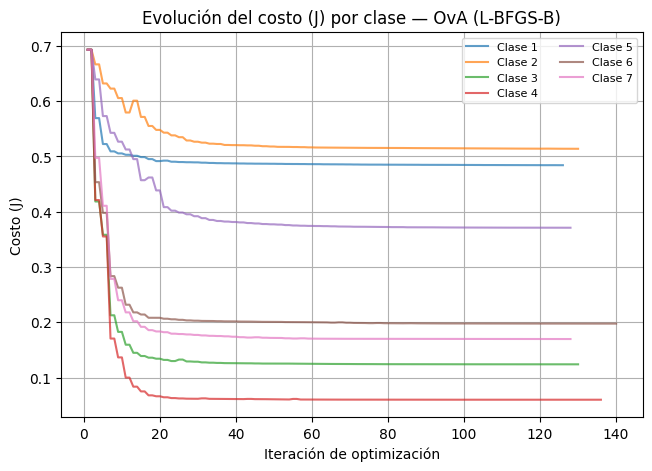

In [39]:
# Graficar costo por clase
plt.figure()
for rec in hist:
    c = rec["costs"]
    plt.plot(range(1, len(c)+1), c, alpha=0.7, label=f"Clase {rec['k']+1}")
plt.title("Evolución del costo (J) por clase — OvA (L-BFGS-B)")
plt.xlabel("Iteración de optimización")
plt.ylabel("Costo (J)")
plt.legend(ncol=2, fontsize=8)
plt.show()


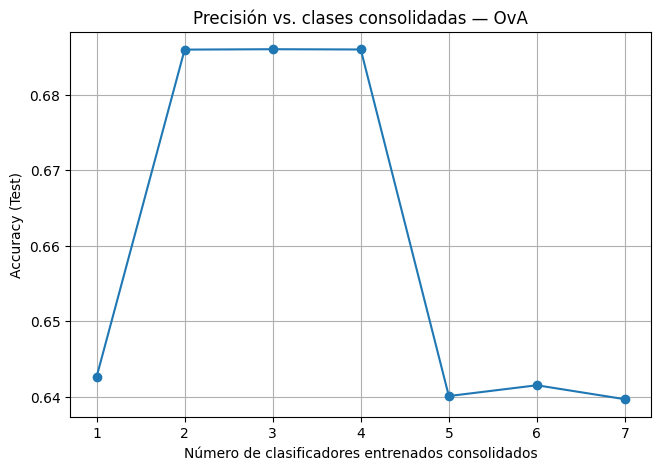

In [40]:
# "Precisión por pasos" (cada 5 iter de costo por clase, volvemos a evaluar)
# Para no re-optimizar, simulamos evaluaciones parciales: guardamos precisiones por k acumulando thetas finales por clase.
# Nota: no hay 'épocas' reales aquí, pero sirve como curva ilustrativa.

# Construimos una secuencia de snapshots (k hasta cierto punto reemplaza por theta final; resto en cero)
snap_acc = []
for upto_k in range(num_labels):
    snap_theta = np.zeros_like(all_theta)
    snap_theta[:upto_k+1, :] = all_theta[:upto_k+1, :]
    y_snap = predict_one_vs_all(snap_theta, X_test)
    snap_acc.append(accuracy_score(y_test, y_snap))

plt.figure()
plt.plot(range(1, num_labels+1), snap_acc, marker="o")
plt.title("Precisión vs. clases consolidadas — OvA")
plt.xlabel("Número de clasificadores entrenados consolidados")
plt.ylabel("Accuracy (Test)")
plt.show()


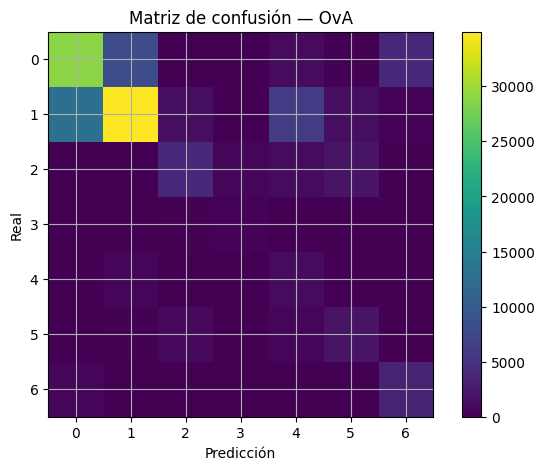

In [41]:
cm = confusion_matrix(y_test, y_pred, labels=np.arange(num_labels))
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Matriz de confusión — OvA")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.colorbar()
plt.show()


In [42]:
idx = np.random.choice(len(y_test), size=10, replace=False)
df_pred = pd.DataFrame({
    "y_real (1..7)": y_test[idx]+1,
    "y_pred (1..7)": y_pred[idx]+1
})
df_pred


,y_real (1..7),y_pred (1..7)
0,2,2
1,2,2
2,1,1
3,2,2
4,2,2
5,2,5
6,1,1
7,1,1
8,2,2
9,1,1


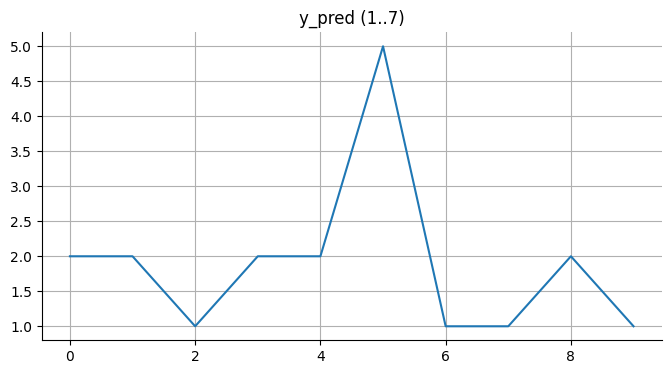

In [43]:
# @title y_pred (1..7)

from matplotlib import pyplot as plt
df_pred['y_pred (1..7)'].plot(kind='line', figsize=(8, 4), title='y_pred (1..7)')
plt.gca().spines[['top', 'right']].set_visible(False)

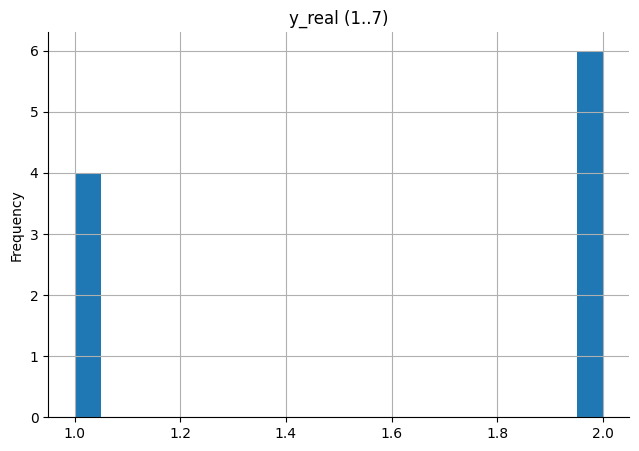

In [44]:
# @title y_real (1..7)

from matplotlib import pyplot as plt
df_pred['y_real (1..7)'].plot(kind='hist', bins=20, title='y_real (1..7)')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [45]:
# Artefactos para el repo
pd.DataFrame(cm).to_csv("confusion_matrix_ova.csv", index=False)
pd.DataFrame({"ACC":[acc], "MacroP":[prec], "MacroR":[rec], "MacroF1":[f1]}).to_csv("metrics_ova.csv", index=False)


In [46]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    multi_class="ovr",   # para comparar con nuestro OvA
    solver="liblinear",  # o 'lbfgs' con 'multinomial' si prefieres
    max_iter=200, class_weight="balanced", n_jobs=-1
)
logreg.fit(X_train, y_train)
y_pred_skl = logreg.predict(X_test)

print("BASELINE (sklearn OVR)")
print("ACC:", accuracy_score(y_test, y_pred_skl))
print(classification_report(y_test, y_pred_skl, digits=3, zero_division=0))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


BASELINE (sklearn OVR)
ACC: 0.6849823154307548
              precision    recall  f1-score   support

           0      0.703     0.678     0.690     42368
           1      0.774     0.701     0.736     56661
           2      0.625     0.710     0.664      7151
           3      0.340     0.643     0.445       549
           4      0.191     0.380     0.254      1899
           5      0.350     0.479     0.404      3473
           6      0.524     0.810     0.637      4102

    accuracy                          0.685    116203
   macro avg      0.501     0.629     0.547    116203
weighted avg      0.706     0.685     0.692    116203

